In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import holidays
import yfinance as yf

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from prophet import Prophet

pd.options.mode.chained_assignment = None

### Supporting functions

In [2]:
def plot_test(df):
    weekly_sales = df.set_index('Date').resample('W').sum()

    weekly_sales.reset_index(inplace=True)

    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Sales'], marker='o', linestyle='-', label='Weekly Sales')
    
    if 'Preds' in weekly_sales.columns:
        plt.plot(weekly_sales['Date'], weekly_sales['Preds'], marker='o', linestyle='-', label='Weekly Sales (predictions)')

    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Sales Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [3]:
def load_data(path: str):
    df = pd.read_excel(path)

    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

#### To provide more information about the context I decided to include DJI to data

In [4]:
dowjones = yf.download('^DJI', start='2023-01-01', end='2024-12-31')

df = load_data('sales_forecast_problem.xlsx')

[*********************100%%**********************]  1 of 1 completed


In [5]:
df = pd.merge(df, dowjones['Close'], on='Date', how='left')

df.rename(columns={'Close': 'DowJones_close'}, inplace=True)

In [6]:
df['DowJones_close'] = df['DowJones_close'].ffill()

scaler = StandardScaler()

scaler.fit(df[['DowJones_close']])

df['DowJones_close_normalized'] = scaler.transform(df[['DowJones_close']])

df.drop(columns=['DowJones_close'], inplace=True)

#### Let's see on the sales over time resampled by week

I decided to visualize it by week to make it more descriptive and to see how the data is distributed

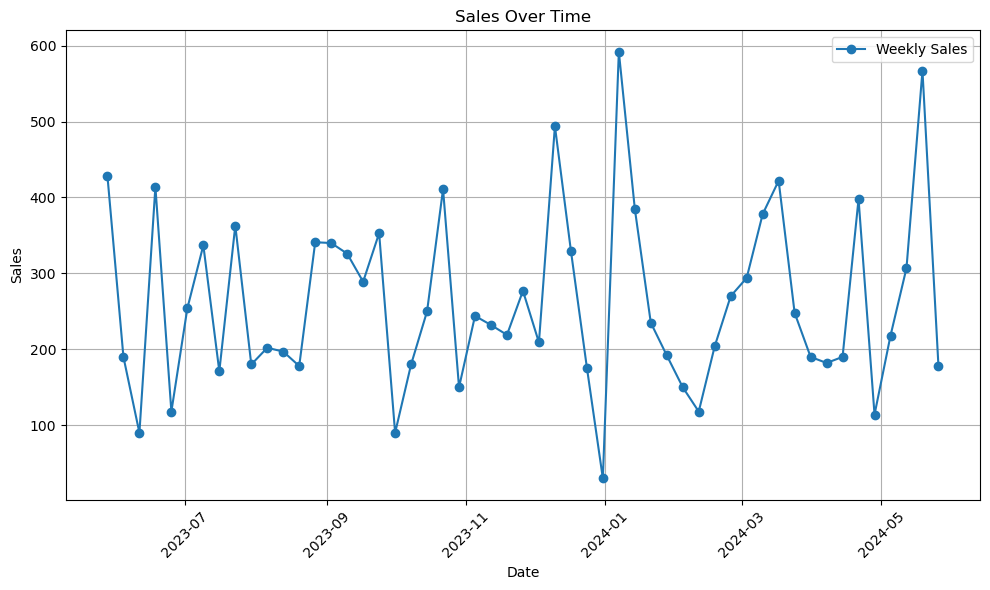

In [7]:
plot_test(df)

#### Extracting features from datetime

In [8]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter.astype('str')
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Is_Month_Start'] = df['Date'].dt.is_month_start
df['Is_Month_End'] = df['Date'].dt.is_month_end
df['Is_weekend'] = df['Date'].apply(lambda x: 1 if x.weekday() >= 5 else 0)

us_holidays = holidays.US()
can_holidays = holidays.Canada()

df['Is_us_holiday'] = df['Date'].apply(lambda x: 1 if x in us_holidays else 0)
df['Is_can_holiday'] = df['Date'].apply(lambda x: 1 if x in can_holidays else 0)

In [9]:
df = df.sort_values(by='Date').reset_index(drop=True)

split_index = int(0.7 * len(df))

df_sales = df[['Date', 'Sales']]

# Split data into training and testing sets
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

# Print lengths of training and testing sets
print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

Training data length: 256
Testing data length: 110


In [10]:
train_data

,Date,Sales,DowJones_close_normalized,Year,Month,Day,Weekday,Week,Quarter,Day_of_Year,Is_Month_Start,Is_Month_End,Is_weekend,Is_us_holiday,Is_can_holiday
0,2023-05-23,30,-1.419411,2023,May,23,Tuesday,21,2,143,False,False,0,0,0
1,2023-05-24,60,-1.535199,2023,May,24,Wednesday,21,2,144,False,False,0,0,0
2,2023-05-25,308,-1.551177,2023,May,25,Thursday,21,2,145,False,False,0,0,0
3,2023-05-26,0,-1.402275,2023,May,26,Friday,21,2,146,False,False,0,0,0
4,2023-05-27,30,-1.402275,2023,May,27,Saturday,21,2,147,False,False,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,2024-01-29,30,0.971598,2024,January,29,Monday,5,1,29,False,False,0,0,0
252,2024-01-30,30,1.032239,2024,January,30,Tuesday,5,1,30,False,False,0,0,0
253,2024-01-31,60,0.888629,2024,January,31,Wednesday,5,1,31,False,True,0,0,0
254,2024-02-01,0,1.056037,2024,February,1,Thursday,5,1,32,True,False,0,0,0


In [11]:
encoder = TargetEncoder(cols=['Weekday', 'Quarter', 'Month'])

train_data = encoder.fit_transform(train_data, train_data['Sales'])
test_data = encoder.transform(test_data)

train_data.head()

,Date,Sales,DowJones_close_normalized,Year,Month,Day,Weekday,Week,Quarter,Day_of_Year,Is_Month_Start,Is_Month_End,Is_weekend,Is_us_holiday,Is_can_holiday
0,2023-05-23,30,-1.419411,2023,40.805641,23,41.662699,21,38.195998,143,False,False,0,0,0
1,2023-05-24,60,-1.535199,2023,40.805641,24,44.862020,21,38.195998,144,False,False,0,0,0
2,2023-05-25,308,-1.551177,2023,40.805641,25,47.878522,21,38.195998,145,False,False,0,0,0
3,2023-05-26,0,-1.402275,2023,40.805641,26,31.310612,21,38.195998,146,False,False,0,0,0
4,2023-05-27,30,-1.402275,2023,40.805641,27,20.065307,21,38.195998,147,False,False,1,0,0


In [12]:
X_train = train_data.drop(['Date', 'Sales'], axis = 1)
X_test = test_data.drop(['Date', 'Sales'], axis = 1)

y_train = train_data['Sales']
y_test = test_data['Sales']

### Using Linear Regression

Baseline model

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 2359.440170895242
Mean Squared Error (test): 3072.4145184083623


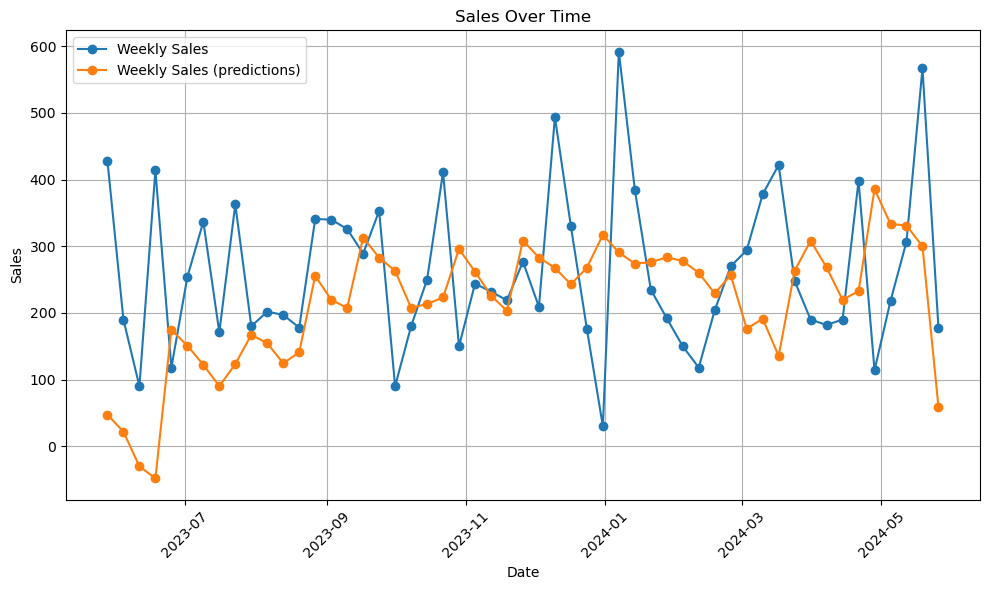

In [16]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['Sales'])

df_sales['Preds'] = sales_pred['Sales']

plot_test(df_sales)

### Using RandomForest Regressor

Baseline model

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [18]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 395.94962851562497
Mean Squared Error (test): 2760.351670909091


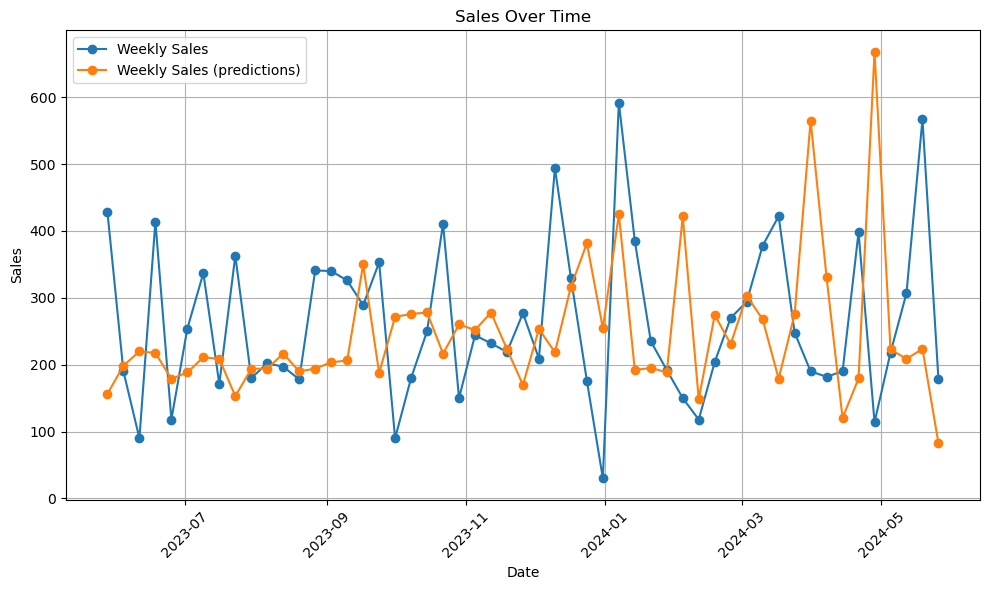

In [20]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['Sales'])

df_sales['Preds'] = sales_pred['Sales']

plot_test(df_sales)

In [21]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [2, 3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [5, 6, 7, 8],
}

tscv = TimeSeriesSplit(n_splits=2)

model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=tscv)

grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

In [22]:
grid_search.best_params_

{'max_depth': 2,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 200}

In [23]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 2304.4547954896375
Mean Squared Error (test): 2562.98363402558


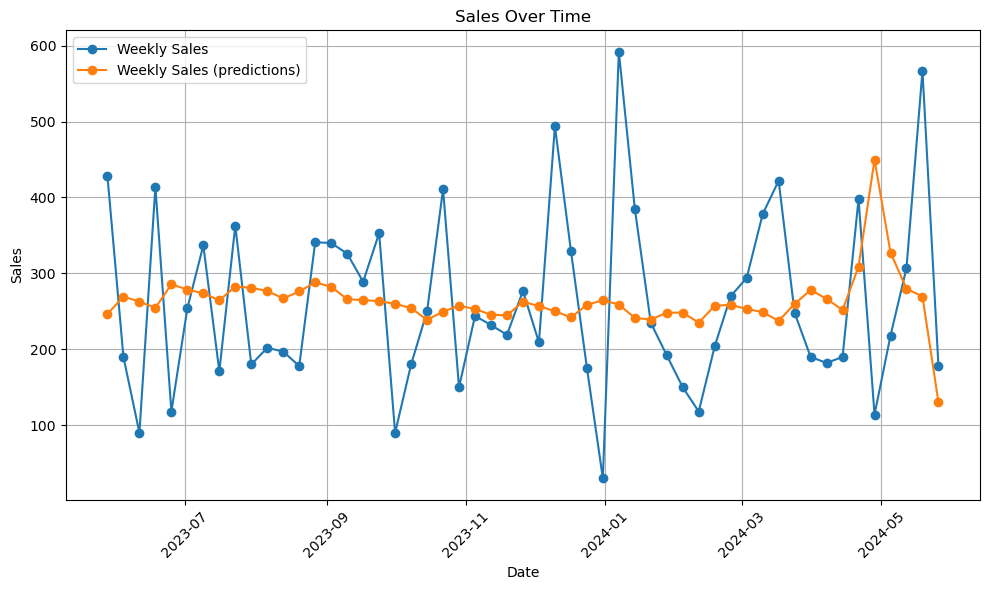

In [24]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['Sales'])

df_sales['Preds'] = sales_pred['Sales']

plot_test(df_sales)

### Using CatBoost Regressor

Baseline model

In [25]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE',
                          random_seed=42)
                          
model.fit(X_train, y_train, verbose=False)

In [26]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 252.80419322263927
Mean Squared Error (test): 2545.155889419262


Results are overfitting the train data so we need go through some regularization and params search

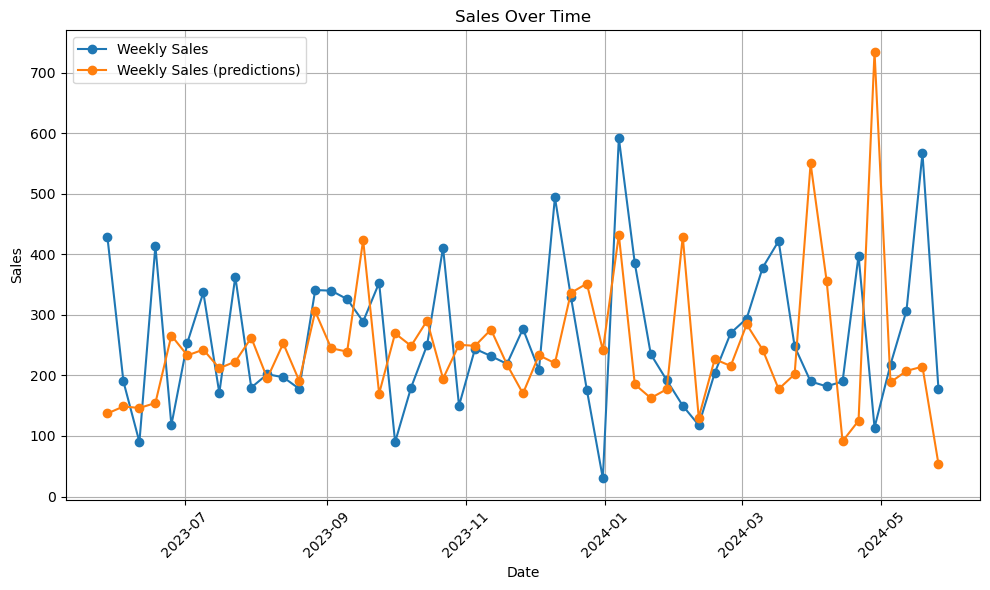

In [27]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['Sales'])

df_sales['Preds'] = sales_pred['Sales']

plot_test(df_sales)

In [28]:
df_sales.to_csv('preds.csv', columns = ['Date', 'Sales'], index=False)

In [29]:
param_grid = {
    'iterations': [50, 100, 150],
    'depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05]
}

tscv = TimeSeriesSplit(n_splits=2)

regressor = CatBoostRegressor()

grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train, verbose=False)

model = grid_search.best_estimator_

In [30]:
grid_search.best_params_

{'depth': 3, 'iterations': 100, 'learning_rate': 0.03}

In [31]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 2109.9692029855482
Mean Squared Error (test): 2571.0839922579885


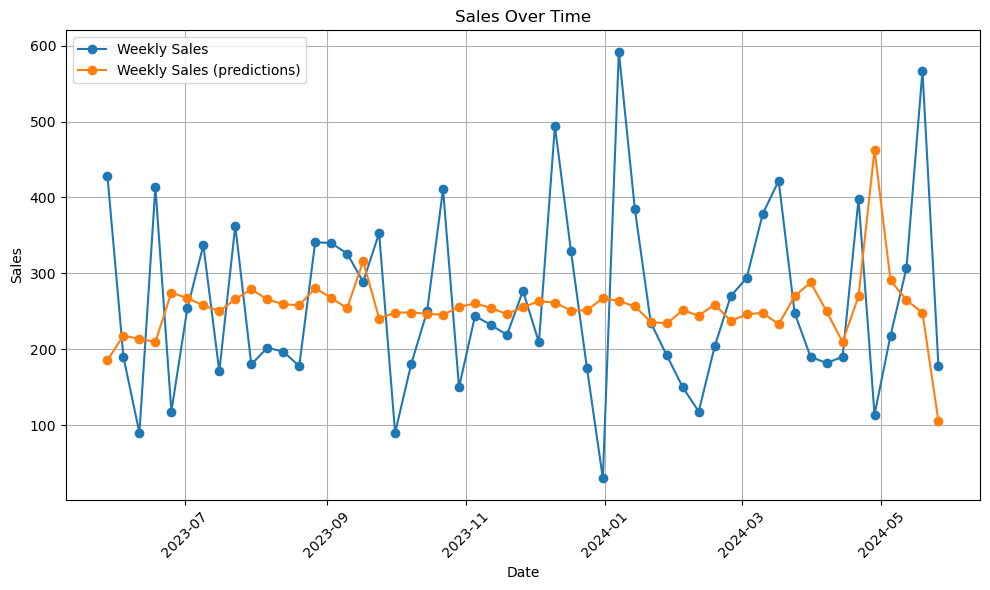

In [32]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['Sales'])

df_sales['Preds'] = sales_pred['Sales']

plot_test(df_sales)

Accordint to train score it's not overfitted as in the baseline model and provide better score on test


In [33]:
feature_importance = model.get_feature_importance(type='PredictionValuesChange')

# Create DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
print(importance_df)

Feature Importances:
                      Feature  Importance
4                     Weekday   30.319765
7                 Day_of_Year   23.536605
0   DowJones_close_normalized   12.122851
10                 Is_weekend   10.013589
3                         Day    9.252371
2                       Month    6.735828
5                        Week    4.437614
6                     Quarter    1.825670
11              Is_us_holiday    1.456731
1                        Year    0.211039
9                Is_Month_End    0.044782
12             Is_can_holiday    0.043153
8              Is_Month_Start    0.000000


### Using Prophet model

The Prophet model, developed by Facebook (now Meta), is a powerful tool designed for time series forecasting

In [34]:
df = load_data('sales_forecast_problem.xlsx')

df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

df = df.sort_values(by='ds').reset_index(drop=True)

split_index = int(0.7 * len(df))

df_sales = df[['ds', 'y']]
df_sales.rename(columns={'ds': 'Date', 'y': 'Sales'}, inplace=True)

# Split data into training and testing sets
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

y_train = train_data['y']
y_test = test_data['y']

In [35]:
model = Prophet()
model.fit(train_data)

# Make predictions
forecast = model.predict(test_data)

17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
y_pred = forecast.yhat
y_train_pred = model.predict(train_data).yhat

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 2453.6491744705813
Mean Squared Error (test): 2612.2066613894817


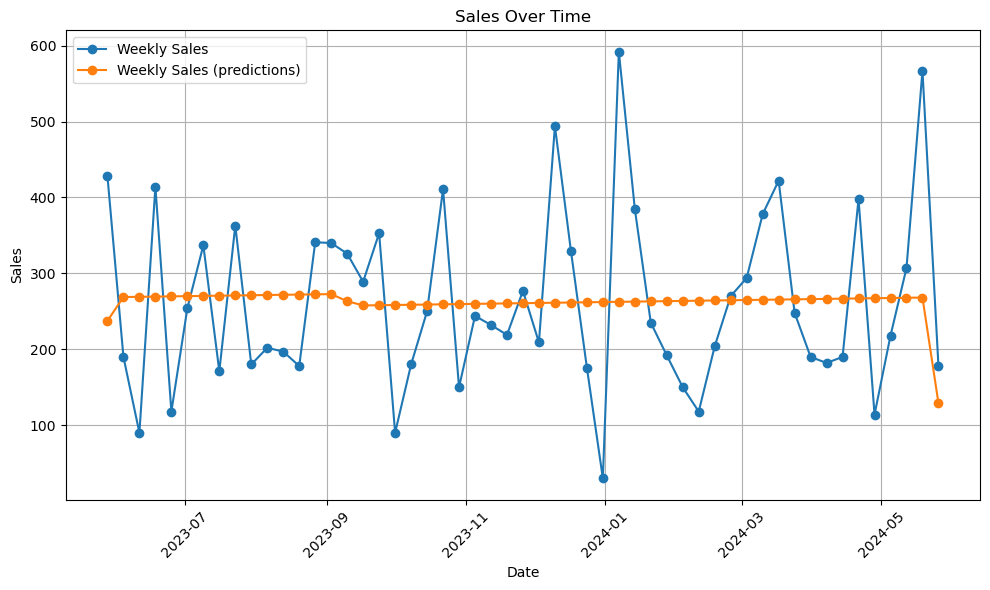

In [37]:
concatenated_array = np.concatenate((y_pred, y_train_pred))

sales_pred = pd.DataFrame(concatenated_array, columns=['y'])

df_sales['Preds'] = sales_pred['y']

plot_test(df_sales)

## Conclusion

In this study, I have explored multiple approaches to researching data and making predictions. The use of machine learning algorithms such as random forests,  Gradient Boosting and Prophet model by Facebook allowed us to leverage patterns within the data, providing predictions in diverse contexts.

The best resault was shown by CatBoostRegressor and RandomForest models.

You will find predictions for test period in preds.csv file in the same folder